<a href="https://colab.research.google.com/github/sayakpaul/A-B-testing-with-Machine-Learning/blob/master/LBW_Pre-trained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/lfw-dataset

 93% 105M/112M [00:01<00:00, 89.0MB/s] 
100% 112M/112M [00:01<00:00, 106MB/s] 


In [0]:
!unzip -qq lfw-dataset.zip

In [0]:
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [0]:
DATASET_PATH ="/content/lfw-deepfunneled"

In [9]:
dataset = []
all_images = paths.list_images(DATASET_PATH)
for path in all_images:
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
dataset.head(10)

,person,path
0,Charlize_Theron,/content/lfw-deepfunneled/lfw-deepfunneled/Cha...
1,Jaromir_Jagr,/content/lfw-deepfunneled/lfw-deepfunneled/Jar...
2,Kevin_Tarrant,/content/lfw-deepfunneled/lfw-deepfunneled/Kev...
3,David_Brown,/content/lfw-deepfunneled/lfw-deepfunneled/Dav...
4,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...
5,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...
6,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...
7,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...
8,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...
9,Lindsay_Davenport,/content/lfw-deepfunneled/lfw-deepfunneled/Lin...


In [10]:
top10_labels = pd.value_counts(dataset["person"], sort=True).head(10).index.tolist()
dataset_frac = dataset[dataset["person"].isin(top10_labels)].reset_index(drop=True)
dataset_frac.shape

(1456, 2)

In [11]:
dataset_frac = dataset_frac.sample(frac=1)
dataset_frac.shape

(1456, 2)

In [0]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [13]:
images, labels = [], []

for (_, row) in tqdm(dataset_frac.iterrows()):
    image = plt.imread(row["path"])
    image = cv2.resize(image, (224, 224))
    image = image/255.
    images.append(image)
    labels.append(row["person"])

images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

1456it [00:04, 353.25it/s]


(1456, 224, 224, 3) (1456,)


In [14]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, 
    stratify=labels, test_size=0.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1237, 224, 224, 3), (219, 224, 224, 3), (1237,), (219,))

In [0]:
lb = LabelEncoder()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

In [0]:
!pip install -q tensorflow-addons

In [17]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [0]:
# Other imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
import io

In [0]:
# Fix random seeds
np.random.seed(666)
tf.random.set_seed(666)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded)).\
    cache().\
    shuffle(1024).\
    batch(64).\
    prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded)).\
    cache().\
    batch(64).\
    prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
def embedding_model(embedding_dim, pretrained_model):
    inputs = Input(shape=(224, 224, 3))
    features = pretrained_model(inputs, training=False)
    
    x = GlobalAveragePooling2D()(features)
    x = Dense(2048, activation="relu")(x)
    x = Dense(embedding_dim)(x)
    outputs = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(x)
    
    model = Model(inputs, outputs)

    return model

In [0]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

In [0]:
# Utility for visualizing the embeddings
# Save test embeddings for visualization in projector
# Reference: https://www.tensorflow.org/addons/tutorials/losses_triplet
def serialize_embeddings(results, vec, meta):
    np.savetxt(vec, results, delimiter='\t', encoding="utf-8") 

    out_m = io.open(meta, 'w', encoding='utf-8')
    for _, labels in test_ds:
        [out_m.write(str(lb.inverse_transform([x])) + "\n") for x in labels.numpy()]
    out_m.close()

In [0]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [0]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 2.6384000000000004e-05


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


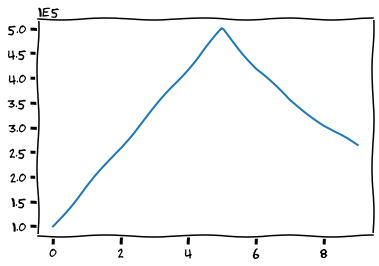

In [30]:
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
with plt.xkcd():
    plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [0]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=2, mode="auto",
    restore_best_weights=True
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 8s 393ms/step - loss: 0.9840 - val_loss: 0.9566 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 6s 320ms/step - loss: 0.7994 - val_loss: 0.6233 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 6s 321ms/step - loss: 0.2881 - val_loss: 0.2224 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
20/20 [==============================] - 6s 315ms/step - loss: 0.2489 - val_loss: 0.2422 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
20/20 [==============================] - 6s 319ms/step - loss: 0.2052 - val_loss: 0.4425 - lr: 4.2000e-05
Ep

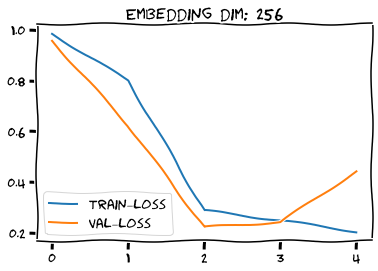

In [49]:
# Inception network Adam
inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
inception.trainable = True

model = embedding_model(256, inception)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 256)

In [0]:
# Visualization 
results = model.predict(test_ds)
serialize_embeddings(results, "vecs.tsv", "meta.tsv")

![](https://i.ibb.co/qRzk2vJ/Screen-Shot-2020-05-07-at-4-55-26-PM.png)

## **Note**: The EarlyStopping callback needs to rerun.


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 8s 398ms/step - loss: 0.9900 - val_loss: 0.9893 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 6s 320ms/step - loss: 0.9906 - val_loss: 0.9893 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 7s 327ms/step - loss: 0.9906 - val_loss: 0.9892 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
20/20 [==============================] - 6s 317ms/step - loss: 0.9908 - val_loss: 0.9892 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
20/20 [==============================] - 7s 325ms/step - loss: 0.9910 - val_loss: 0.9891 - lr: 4.2000e-05

E

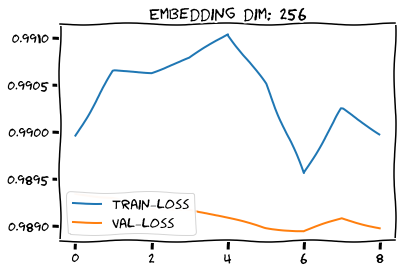

In [51]:
# Inception network with Adagrad
inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
inception.trainable = True

model = embedding_model(256, inception)
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 256)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 8s 400ms/step - loss: 0.9913 - val_loss: 0.9896 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 6s 312ms/step - loss: 0.9906 - val_loss: 0.9896 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 6s 319ms/step - loss: 0.9911 - val_loss: 0.9896 - lr: 2.6000e-05
Epoch 00003: early stopping


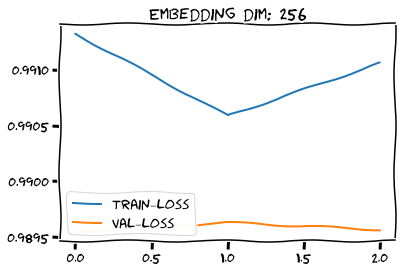

In [53]:
# Inception network with SGD
inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
inception.trainable = True

model = embedding_model(256, inception)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 256)

58892288/58889256 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 11s 556ms/step - loss: 0.9980 - val_loss: 0.9945 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 9s 447ms/step - loss: 0.9445 - val_loss: 0.8328 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 9s 447ms/step - loss: 0.5008 - val_loss: 0.6172 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
20/20 [==============================] - 9s 447ms/step - loss: 0.4282 - val_loss: 0.5487 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
20/20 [==============================] - 9

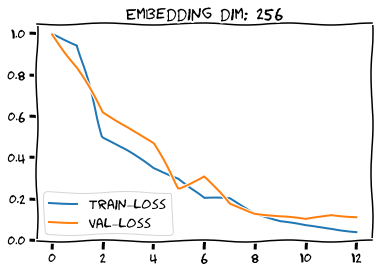

In [54]:
# VGG16 network Adam
vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(256, vgg_16)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 256)

In [0]:
# Visualization 
results = model.predict(test_ds)
serialize_embeddings(results, "vecs.tsv", "meta.tsv")

![](https://i.ibb.co/bRDj27T/Screen-Shot-2020-05-07-at-5-21-34-PM.png)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 8s 394ms/step - loss: 0.9864 - val_loss: 0.9601 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 6s 322ms/step - loss: 0.8035 - val_loss: 0.5816 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 6s 322ms/step - loss: 0.3126 - val_loss: 0.3742 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
20/20 [==============================] - 6s 313ms/step - loss: 0.2086 - val_loss: 0.3951 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
20/20 [==============================] - 6s 319ms/step - loss: 0.1921 - val_loss: 0.7039 - lr: 4.2000e-05
Ep

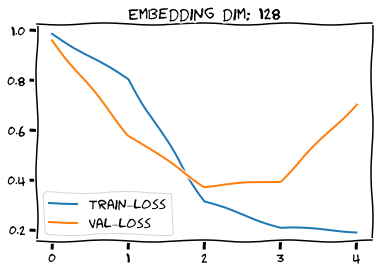

In [56]:
# Inception network with Adam with 128-d embeddings
inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
inception.trainable = True

model = embedding_model(128, inception)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 128)

In [0]:
# Visualization 
results = model.predict(test_ds)
serialize_embeddings(results, "vecs.tsv", "meta.tsv")

![](https://i.ibb.co/mTqk2tx/Screen-Shot-2020-05-07-at-5-26-25-PM.png)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
20/20 [==============================] - 9s 458ms/step - loss: 0.9980 - val_loss: 0.9953 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
20/20 [==============================] - 9s 447ms/step - loss: 0.9124 - val_loss: 0.6782 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
20/20 [==============================] - 9s 447ms/step - loss: 0.6647 - val_loss: 0.4525 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
20/20 [==============================] - 9s 447ms/step - loss: 0.4679 - val_loss: 0.7069 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
20/20 [==============================] - 9s 449ms/step - loss: 0.3839 - val_loss: 0.4375 - lr: 4.2000e-05

E

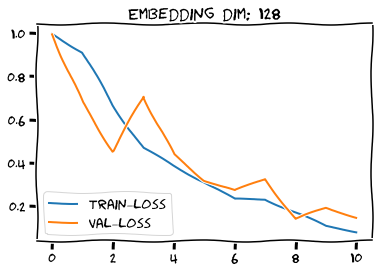

In [58]:
# VGG16 network Adam with 128-d embeddings
vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(128, vgg_16)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 128)

In [0]:
# Visualization 
results = model.predict(test_ds)
serialize_embeddings(results, "vecs.tsv", "meta.tsv")

![](https://i.ibb.co/rd7B3MV/Screen-Shot-2020-05-07-at-5-34-07-PM.png)